In [2]:
# imports
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.stats import linregress, pearsonr, spearmanr

# no max rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# load in node ids, crash avg, census tract ids
node_info = pd.read_pickle("../../data/consolidated_danger_by_node_id.pkl.gz")

node_info.head()

,DANGER,OLD_NODE_IDS,CENSUS_TRACT_ID
0,0.000000,[42421828],2800
1,4.722819,[42430942],2400
2,3.771228,[42430938],2800
3,0.000000,"[42421837, 5481976931, 5481976926]",2800
4,4.090534,"[42421877, 8475999052, 42433354, 42437949, 830...",6300


In [5]:
# load in census race and income data
race_income = pd.read_csv('../../data/census_race_income_clean.csv')

# load in census transportation and departure time data
transp_depart = pd.read_csv('../../data/census_transportation_departure_time_clean.csv')

race_income.head()

,Unnamed: 0,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,CENSUS_TRACT,RACE_TOTAL,WHITE,BLACK,AMERICAN_INDIAN,ASIAN,HISPANIC,INCOME_TOTAL,LESS_THAN_10000,100000_TO_124999,125000_TO_149999,150000_TO_199999,200000_OR_MORE,10000_TO_24999,25000_TO_49999,50000_TO_99999,WHITE_PERCENT,BLACK_PERCENT,AMERICAN_INDIAN_PERCENT,ASIAN_PERCENT,HISPANIC_PERCENT,LESS_THAN_10000_PERCENT,100000_TO_124999_PERCENT,125000_TO_149999_PERCENT,150000_TO_199999_PERCENT,200000_OR_MORE_PERCENT,10000_TO_24999_PERCENT,25000_TO_49999_PERCENT,50000_TO_99999_PERCENT
0,0,1,1009800,Manhattan,I,9800,98.0,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200306,POLYGON ((-73.96432543478758 40.75638153099091...,9800,7302,5510,153,10,791,718,4242,136,249,252,347,1585,475,308,890,75.458778,2.095316,0.136949,10.832649,9.832922,3.206035,5.869873,5.940594,8.180104,37.364451,11.197548,7.260726,20.980669
1,1,1,1010200,Manhattan,I,10200,102.0,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...,10200,122,67,7,28,2,14,66,5,8,18,0,4,26,0,5,54.918033,5.737705,22.950820,1.639344,11.475410,7.575758,12.121212,27.272727,0.000000,6.060606,39.393939,0.000000,7.575758
2,2,1,1010400,Manhattan,I,10400,104.0,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...,10400,811,511,12,0,156,73,522,22,76,53,41,173,42,20,95,63.008631,1.479655,0.000000,19.235512,9.001233,4.214559,14.559387,10.153257,7.854406,33.141762,8.045977,3.831418,18.199234
3,3,1,1011300,Manhattan,I,11300,113.0,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860712,"POLYGON ((-73.98411754823195 40.7548420534646,...",11300,98,15,38,0,33,0,53,11,5,10,5,3,0,7,12,15.306122,38.775510,0.000000,33.673469,0.000000,20.754717,9.433962,18.867925,9.433962,5.660377,0.000000,13.207547,22.641509
4,4,1,1013000,Manhattan,I,13000,130.0,MN40,Upper East Side-Carnegie Hill,3805,1.918145e+06,5807.972956,POLYGON ((-73.96147581181627 40.77432401139124...,13000,3314,2894,20,0,144,181,1789,24,102,17,159,893,50,192,352,87.326494,0.603500,0.000000,4.345202,5.461678,1.341532,5.701509,0.950252,8.887647,49.916154,2.794857,10.732253,19.675797


In [6]:
transp_depart.head()

,Unnamed: 0,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,CENSUS_TRACT,TRANSP_TOTAL,CAR,BUS,SUBWAY,TRAIN_RAIL,TROLLEY,FERRY,TAXI,MOTORCYCLE,BICYCLE,WALKED,TRANSP_OTHER,WORKED_FROM_HOME,DEPART_TOTAL,12AM_4:59AM,5AM_5:29AM,5:30AM_5:59AM,6AM_6:29AM,6:30AM_6:59AM,7AM_7:29AM,7:30AM_7:59AM,8AM_8:29AM,8:30AM_8:59AM,9AM_9:59AM,10AM_10:59AM,11AM_11:59AM,12PM_3:59PM,4PM_11:59PM,CAR_PERCENT,BUS_PERCENT,SUBWAY_PERCENT,TRAIN_RAIL_PERCENT,TROLLEY_PERCENT,FERRY_PERCENT,TAXI_PERCENT,MOTORCYCLE_PERCENT,BICYCLE_PERCENT,WALKED_PERCENT,TRANSP_OTHER_PERCENT,WORKED_FROM_HOME_PERCENT,12AM_4:59AM_PERCENT,5AM_5:29AM_PERCENT,5:30AM_5:59AM_PERCENT,6AM_6:29AM_PERCENT,6:30AM_6:59AM_PERCENT,7AM_7:29AM_PERCENT,7:30AM_7:59AM_PERCENT,8AM_8:29AM_PERCENT,8:30AM_8:59AM_PERCENT,9AM_9:59AM_PERCENT,10AM_10:59AM_PERCENT,11AM_11:59AM_PERCENT,12PM_3:59PM_PERCENT,4PM_11:59PM_PERCENT
0,0,1,1009800,Manhattan,I,9800,98.0,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200306,POLYGON ((-73.96432543478758 40.75638153099091...,9800,4557,375,20,1389,52,0,8,24,0,19,2068,21,581,3976,18,66,30,0,130,306,297,1140,909,790,33,49,63,145,8.229098,0.438885,30.480579,1.141102,0.0,0.175554,0.526662,0.0,0.416941,45.380733,0.460829,12.749616,0.452716,1.65996,0.754527,0.000000,3.269618,7.696177,7.469819,28.672032,22.862173,19.869215,0.829980,1.232394,1.584507,3.646881
1,1,1,1010200,Manhattan,I,10200,102.0,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...,10200,63,7,2,14,0,0,0,0,0,4,18,4,14,49,0,0,0,0,0,8,4,3,9,10,0,2,4,9,11.111111,3.174603,22.222222,0.000000,0.0,0.000000,0.000000,0.0,6.349206,28.571429,6.349206,22.222222,0.000000,0.00000,0.000000,0.000000,0.000000,16.326531,8.163265,6.122449,18.367347,20.408163,0.000000,4.081633,8.163265,18.367347
2,2,1,1010400,Manhattan,I,10400,104.0,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...,10400,569,10,5,211,0,0,5,0,0,1,244,0,93,476,0,0,0,18,0,21,58,78,143,137,0,13,8,0,1.757469,0.878735,37.082601,0.000000,0.0,0.878735,0.000000,0.0,0.175747,42.882250,0.000000,16.344464,0.000000,0.00000,0.000000,3.781513,0.000000,4.411765,12.184874,16.386555,30.042017,28.781513,0.000000,2.731092,1.680672,0.000000
3,3,1,1011300,Manhattan,I,11300,113.0,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860712,"POLYGON ((-73.98411754823195 40.7548420534646,...",11300,51,0,0,17,0,0,0,0,0,0,34,0,0,51,0,0,0,3,0,0,0,9,13,18,5,3,0,0,0.000000,0.000000,33.333333,0.000000,0.0,0.000000,0.000000,0.0,0.000000,66.666667,0.000000,0.000000,0.000000,0.00000,0.000000,5.882353,0.000000,0.000000,0.000000,17.647059,25.490196,35.294118,9.803922,5.882353,0.000000,0.000000
4,4,1,1013000,Manhattan,I,13000,130.0,MN40,Upper East Side-Carnegie Hill,3805,1.918145e+06,5807.972956,POLYGON ((-73.96147581181627 40.77432401139124...,13000,1546,291,219,365,25,0,0,140,0,16,320,68,102,1444,0,24,16,12,35,120,179,298,339,217,95,53,56,0,18.822768,14.165589,23.609314,1.617076,0.0,0.000000,9.055627,0.0,1.034929,20.698577,4.398448,6.597671,0.000000,1.66205,1.108033,0.831025,2.423823,8.310249,12.396122,20.637119,23.476454,15.027701,6.578947,3.670360,3.878116,0.000000


In [20]:
node_info = node_info.query('DANGER > 0')

In [21]:
# join on census tract ID
node_crash_race_income = node_info.merge(race_income, how='left', left_on='CENSUS_TRACT_ID',right_on='CENSUS_TRACT')
node_crash_transp_depart = node_info.merge(transp_depart, how='left', left_on='CENSUS_TRACT_ID',right_on='CENSUS_TRACT')


# check shape
print("race & income shape: ",node_crash_race_income.shape)
print("transportation & departure time shape: ",node_crash_transp_depart.shape)

race & income shape:  (861, 45)
transportation & departure time shape:  (861, 71)


In [22]:
# examine head
node_crash_race_income.head()

,DANGER,OLD_NODE_IDS,CENSUS_TRACT_ID,Unnamed: 0,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,CENSUS_TRACT,RACE_TOTAL,WHITE,BLACK,AMERICAN_INDIAN,ASIAN,HISPANIC,INCOME_TOTAL,LESS_THAN_10000,100000_TO_124999,125000_TO_149999,150000_TO_199999,200000_OR_MORE,10000_TO_24999,25000_TO_49999,50000_TO_99999,WHITE_PERCENT,BLACK_PERCENT,AMERICAN_INDIAN_PERCENT,ASIAN_PERCENT,HISPANIC_PERCENT,LESS_THAN_10000_PERCENT,100000_TO_124999_PERCENT,125000_TO_149999_PERCENT,150000_TO_199999_PERCENT,200000_OR_MORE_PERCENT,10000_TO_24999_PERCENT,25000_TO_49999_PERCENT,50000_TO_99999_PERCENT
0,4.722819,[42430942],2400,254,1,1002400,Manhattan,E,2400,24.0,MN28,Lower East Side,3809,1.862478e+06,9194.919307,MULTIPOLYGON (((-73.96715101172607 40.71831612...,2400,4192,43,641,0,545,2815,1850,546,0,0,0,9,694,435,166,1.025763,15.291031,0.0,13.000954,67.151718,29.513514,0.000000,0.000000,0.000000,0.486486,37.513514,23.513514,8.972973
1,3.771228,[42430938],2800,167,1,1002800,Manhattan,E,2800,28.0,MN28,Lower East Side,3809,1.973678e+06,5627.555017,POLYGON ((-73.97329796772085 40.72742800885976...,2800,6765,2234,1080,0,1037,2289,3385,471,168,149,177,392,751,672,605,33.022912,15.964523,0.0,15.328899,33.835920,13.914328,4.963072,4.401773,5.228951,11.580502,22.186115,19.852290,17.872969
2,4.090534,"[42421877, 8475999052, 42433354, 42437949, 830...",6300,95,1,1006300,Manhattan,I,6300,63.0,MN23,West Village,3810,1.918266e+06,5802.508440,POLYGON ((-73.99361688329428 40.73600449161599...,6300,6393,5359,67,0,435,300,3359,172,250,334,407,1398,160,219,419,83.826060,1.048021,0.0,6.804317,4.692633,5.120572,7.442691,9.943436,12.116701,41.619530,4.763322,6.519798,12.473951
3,3.157482,"[42421889, 42432191, 42430237]",7100,144,1,1007100,Manhattan,I,7100,71.0,MN23,West Village,3810,1.775764e+06,6601.177174,"POLYGON ((-73.9968399392649 40.7373608893982, ...",7100,5530,4554,191,0,342,217,3111,53,366,171,488,1208,154,275,396,82.350814,3.453888,0.0,6.184448,3.924051,1.703632,11.764706,5.496625,15.686275,38.829958,4.950177,8.839601,12.729026
4,2.745500,[42430241],6300,95,1,1006300,Manhattan,I,6300,63.0,MN23,West Village,3810,1.918266e+06,5802.508440,POLYGON ((-73.99361688329428 40.73600449161599...,6300,6393,5359,67,0,435,300,3359,172,250,334,407,1398,160,219,419,83.826060,1.048021,0.0,6.804317,4.692633,5.120572,7.442691,9.943436,12.116701,41.619530,4.763322,6.519798,12.473951


In [23]:
# examine head
node_crash_transp_depart.head()

,DANGER,OLD_NODE_IDS,CENSUS_TRACT_ID,Unnamed: 0,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,CENSUS_TRACT,TRANSP_TOTAL,CAR,BUS,SUBWAY,TRAIN_RAIL,TROLLEY,FERRY,TAXI,MOTORCYCLE,BICYCLE,WALKED,TRANSP_OTHER,WORKED_FROM_HOME,DEPART_TOTAL,12AM_4:59AM,5AM_5:29AM,5:30AM_5:59AM,6AM_6:29AM,6:30AM_6:59AM,7AM_7:29AM,7:30AM_7:59AM,8AM_8:29AM,8:30AM_8:59AM,9AM_9:59AM,10AM_10:59AM,11AM_11:59AM,12PM_3:59PM,4PM_11:59PM,CAR_PERCENT,BUS_PERCENT,SUBWAY_PERCENT,TRAIN_RAIL_PERCENT,TROLLEY_PERCENT,FERRY_PERCENT,TAXI_PERCENT,MOTORCYCLE_PERCENT,BICYCLE_PERCENT,WALKED_PERCENT,TRANSP_OTHER_PERCENT,WORKED_FROM_HOME_PERCENT,12AM_4:59AM_PERCENT,5AM_5:29AM_PERCENT,5:30AM_5:59AM_PERCENT,6AM_6:29AM_PERCENT,6:30AM_6:59AM_PERCENT,7AM_7:29AM_PERCENT,7:30AM_7:59AM_PERCENT,8AM_8:29AM_PERCENT,8:30AM_8:59AM_PERCENT,9AM_9:59AM_PERCENT,10AM_10:59AM_PERCENT,11AM_11:59AM_PERCENT,12PM_3:59PM_PERCENT,4PM_11:59PM_PERCENT
0,4.722819,[42430942],2400,254,1,1002400,Manhattan,E,2400,24.0,MN28,Lower East Side,3809,1.862478e+06,9194.919307,MULTIPOLYGON (((-73.96715101172607 40.71831612...,2400,1017,38,267,540,0,0,0,28,0,7,101,0,36,981,35,39,0,0,20,303,126,168,41,77,73,0,56,43,3.736480,26.253687,53.097345,0.000000,0.0,0.0,2.753196,0.0,0.688299,9.931170,0.000000,3.539823,3.567788,3.975535,0.000000,0.000000,2.038736,30.886850,12.844037,17.125382,4.179409,7.849134,7.441386,0.000000,5.708461,4.383282
1,3.771228,[42430938],2800,167,1,1002800,Manhattan,E,2800,28.0,MN28,Lower East Side,3809,1.973678e+06,5627.555017,POLYGON ((-73.97329796772085 40.72742800885976...,2800,3272,207,597,1532,27,0,0,30,0,261,533,0,85,3187,0,12,27,78,180,367,249,681,541,520,229,67,84,152,6.326406,18.245721,46.821516,0.825183,0.0,0.0,0.916870,0.0,7.976773,16.289731,0.000000,2.597800,0.000000,0.376530,0.847192,2.447443,5.647945,11.515532,7.812990,21.368058,16.975212,16.316285,7.185441,2.102291,2.635708,4.769376
2,4.090534,"[42421877, 8475999052, 42433354, 42437949, 830...",6300,95,1,1006300,Manhattan,I,6300,63.0,MN23,West Village,3810,1.918266e+06,5802.508440,POLYGON ((-73.99361688329428 40.73600449161599...,6300,3927,263,113,2016,17,0,0,187,0,73,802,39,417,3510,0,19,47,102,98,298,298,450,813,849,230,107,89,110,6.697224,2.877515,51.336898,0.432900,0.0,0.0,4.761905,0.0,1.858925,20.422715,0.993125,10.618793,0.000000,0.541311,1.339031,2.905983,2.792023,8.490028,8.490028,12.820513,23.162393,24.188034,6.552707,3.048433,2.535613,3.133903
3,3.157482,"[42421889, 42432191, 42430237]",7100,144,1,1007100,Manhattan,I,7100,71.0,MN23,West Village,3810,1.775764e+06,6601.177174,"POLYGON ((-73.9968399392649 40.7373608893982, ...",7100,3524,221,43,1696,36,0,0,143,0,198,843,47,297,3227,0,0,0,46,185,281,319,609,910,615,81,5,29,147,6.271283,1.220204,48.127128,1.021566,0.0,0.0,4.057889,0.0,5.618615,23.921680,1.333712,8.427923,0.000000,0.000000,0.000000,1.425473,5.732879,8.707778,9.885342,18.872017,28.199566,19.057949,2.510071,0.154943,0.898667,4.555315
4,2.745500,[42430241],6300,95,1,1006300,Manhattan,I,6300,63.0,MN23,West Village,3810,1.918266e+06,5802.508440,POLYGON ((-73.99361688329428 40.73600449161599...,6300,3927,263,113,2016,17,0,0,187,0,73,802,39,417,3510,0,19,47,102,98,298,298,450,813,849,230,107,89,110,6.697224,2.877515,51.336898,0.432900,0.0,0.0,4.761905,0.0,1.858925,20.422715,0.993125,10.618793,0.000000,0.541311,1.339031,2.905983,2.792023,8.490028,8.490028,12.820513,23.162393,24.188034,6.552707,3.048433,2.535613,3.133903


In [24]:
# white percent test
fitted_model = sm.OLS.from_formula('DANGER ~ WHITE_PERCENT', data=node_crash_race_income).fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 DANGER   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     66.18
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           1.44e-15
Time:                        11:01:35   Log-Likelihood:                -1147.2
No. Observations:                 860   AIC:                             2298.
Df Residuals:                     858   BIC:                             2308.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.9731      0.092     43.228      0.000       3.793       4.153
WHITE_PERCENT    -0.0118      0.001     -8.135      0.000      -0.015      -0.009
==============================================================================
Omnibus:                        1.524   Durbin-Watson:                   1.590
Prob(Omnibus):                  0.467   Jarque-Bera (JB):                1.428
Skew:                          -0.032   Prob(JB):                        0.490
Kurtosis:                       3.189   Cond. No.                         186.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

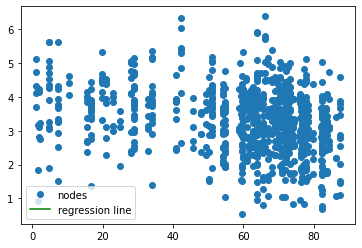

In [25]:
# white percent test
x_values = node_crash_race_income['WHITE_PERCENT']
y_values = node_crash_race_income['DANGER']

slope, intercept, _, _, _ = stats.linregress(x_values, y_values)


plt.plot(x_values, y_values, 'o', label='nodes')
plt.plot(x_values, intercept + slope*x_values, 'g', label='regression line')
plt.legend()
plt.show()

In [26]:
# income percent test
income_fitted_model = sm.OLS.from_formula('DANGER ~ LESS_THAN_10000_PERCENT', data=node_crash_race_income).fit()
income_fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 DANGER   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     25.64
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           5.04e-07
Time:                        11:01:35   Log-Likelihood:                -1166.4
No. Observations:                 860   AIC:                             2337.
Df Residuals:                     858   BIC:                             2346.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   3.0549      0.053     57.349      0.000       2.950       3.159
LESS_THAN_10000_PERCENT     0.0303      0.006      5.063      0.000       0.019       0.042
==============================================================================
Omnibus:                        0.693   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.707   Jarque-Bera (JB):                0.552
Skew:                           0.001   Prob(JB):                        0.759
Kurtosis:                       3.124   Cond. No.                         14.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

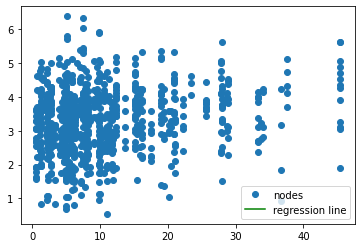

In [27]:
# income percent test
x_values = node_crash_race_income['10000_TO_24999_PERCENT']
y_values = node_crash_race_income['DANGER']

slope, intercept, _, _, _ = stats.linregress(x_values, y_values)


plt.plot(x_values, y_values, 'o', label='nodes')
plt.plot(x_values, intercept + slope*x_values, 'g', label='regression line')
plt.legend()
plt.show()

In [28]:
# look at tranportation mode and departure time columns
node_crash_transp_depart.columns

Index(['DANGER', 'OLD_NODE_IDS', 'CENSUS_TRACT_ID', 'Unnamed: 0', 'boro_code',
       'boro_ct201', 'boro_name', 'cdeligibil', 'ct2010', 'ctlabel', 'ntacode',
       'ntaname', 'puma', 'shape_area', 'shape_leng', 'geometry',
       'CENSUS_TRACT', 'TRANSP_TOTAL', 'CAR', 'BUS', 'SUBWAY', 'TRAIN_RAIL',
       'TROLLEY', 'FERRY', 'TAXI', 'MOTORCYCLE', 'BICYCLE', 'WALKED',
       'TRANSP_OTHER', 'WORKED_FROM_HOME', 'DEPART_TOTAL', '12AM_4:59AM',
       '5AM_5:29AM', '5:30AM_5:59AM', '6AM_6:29AM', '6:30AM_6:59AM',
       '7AM_7:29AM', '7:30AM_7:59AM', '8AM_8:29AM', '8:30AM_8:59AM',
       '9AM_9:59AM', '10AM_10:59AM', '11AM_11:59AM', '12PM_3:59PM',
       '4PM_11:59PM', 'CAR_PERCENT', 'BUS_PERCENT', 'SUBWAY_PERCENT',
       'TRAIN_RAIL_PERCENT', 'TROLLEY_PERCENT', 'FERRY_PERCENT',
       'TAXI_PERCENT', 'MOTORCYCLE_PERCENT', 'BICYCLE_PERCENT',
       'WALKED_PERCENT', 'TRANSP_OTHER_PERCENT', 'WORKED_FROM_HOME_PERCENT',
       '12AM_4:59AM_PERCENT', '5AM_5:29AM_PERCENT', '5:30AM_5:59AM_PERCE

In [29]:
# transportation mode percent test
transp_fitted_model = sm.OLS.from_formula('DANGER ~ BICYCLE_PERCENT', data=node_crash_transp_depart).fit()
transp_fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 DANGER   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.053
Date:                Sat, 27 Nov 2021   Prob (F-statistic):              0.305
Time:                        11:01:36   Log-Likelihood:                -1178.6
No. Observations:                 860   AIC:                             2361.
Df Residuals:                     858   BIC:                             2371.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.3157      0.055     60.370      0.000       3.208       3.423
BICYCLE_PERCENT    -0.0134      0.013     -1.026      0.305      -0.039       0.012
==============================================================================
Omnibus:                        0.201   Durbin-Watson:                   1.497
Prob(Omnibus):                  0.904   Jarque-Bera (JB):                0.111
Skew:                          -0.007   Prob(JB):                        0.946
Kurtosis:                       3.054   Cond. No.                         7.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

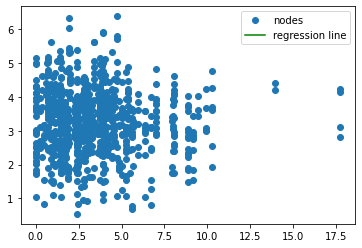

In [30]:
# transportation mode percent test
x_values = node_crash_transp_depart['BICYCLE_PERCENT']
y_values = node_crash_transp_depart['DANGER']

slope, intercept, _, _, _ = stats.linregress(x_values, y_values)


plt.plot(x_values, y_values, 'o', label='nodes')
plt.plot(x_values, intercept + slope*x_values, 'g', label='regression line')
plt.legend()
plt.show()

In [31]:
# departure time percent test
transp_fitted_model = sm.OLS.from_formula('DANGER ~ WORKED_FROM_HOME_PERCENT', data=node_crash_transp_depart).fit()
transp_fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 DANGER   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     22.85
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           2.06e-06
Time:                        11:01:36   Log-Likelihood:                -1167.8
No. Observations:                 860   AIC:                             2340.
Df Residuals:                     858   BIC:                             2349.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.5694      0.070     50.743      0.000       3.431       3.707
WORKED_FROM_HOME_PERCENT    -0.0399      0.008     -4.780      0.000      -0.056      -0.023
==============================================================================
Omnibus:                        0.943   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.624   Jarque-Bera (JB):                0.878
Skew:                          -0.077   Prob(JB):                        0.645
Kurtosis:                       3.026   Cond. No.                         18.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

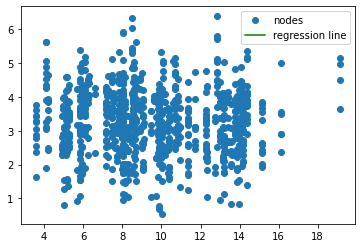

In [32]:
# departure time percent test
x_values = node_crash_transp_depart['7:30AM_7:59AM_PERCENT']
y_values = node_crash_transp_depart['DANGER']

slope, intercept, _, _, _ = stats.linregress(x_values, y_values)


plt.plot(x_values, y_values, 'o', label='nodes')
plt.plot(x_values, intercept + slope*x_values, 'g', label='regression line')
plt.legend()
plt.show()